In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
data_path = "dataset/dataset/*.html"

code2convos = dict()
total_code_response_list = []
pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    code_block_count = 0
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
        html_page = fh.read()
        soup = BeautifulSoup(html_page, "html.parser")

        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})
        convo_texts = []
        last_user_text = None  # Keep track of the last user message

        for i, convo in enumerate(conversations):
            user_div = convo.find("div", attrs={"data-message-author-role": "user"})
            assistant_div = convo.find("div", attrs={"data-message-author-role": "assistant"})

            # When a user message is found, save it to last_user_text
            if user_div:
                last_user_text = user_div.text.strip()
            if assistant_div and assistant_div.find("code"):  # This assumes that <code> tags are used for code blocks
                code_block_count += 1

            # When an assistant message follows a user message, pair them
            if assistant_div and last_user_text is not None:
                convo_texts.append({
                    "role": "user",
                    "text": last_user_text,
                    "response": assistant_div.text.strip()  # Pair with the last user message
                })
                last_user_text = None  # Reset last_user_text after pairing
        total_code_response_list.append((file_code, code_block_count))
        
        code2convos[file_code] = convo_texts
total_code_response_df = pd.DataFrame(total_code_response_list, columns=['code', 'code_responses'])


  0%|          | 0/127 [00:00<?, ?it/s]

100%|██████████| 127/127 [00:29<00:00,  4.36it/s]


In [241]:
import tqdm
import glob
import os
from bs4 import BeautifulSoup
import re

data_path = "dataset/dataset/*.html"

code2convos2 = dict()
pbar = tqdm.tqdm(sorted(list(glob.glob(data_path))))
for path in pbar:
    file_code = os.path.basename(path).split(".")[0]

    with open(path, "r", encoding="latin1") as fh:
        html_page = fh.read()
        soup = BeautifulSoup(html_page, "html.parser")

        # Find all conversations in the document
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})
        
        # Initialize an empty list for storing code blocks for this file_code
        code_blocks = []

        for convo in conversations:
            # Find the assistant's part in the conversation
            assistant_div = convo.find("div", attrs={"data-message-author-role": "assistant"})
            if assistant_div:
                # Find all code blocks within the assistant's part
                for code_block in assistant_div.find_all("code"):
                    # Add the code block text to the list for this file_code
                    code_blocks.append(code_block.get_text(strip=True))

        # Store the list of code blocks in the dictionary with file_code as the key
        code2convos2[file_code] = code_blocks

# Now code2convos has each file_code as a key and a list of its code blocks as the value


  0%|          | 0/127 [00:00<?, ?it/s]

100%|██████████| 127/127 [00:19<00:00,  6.46it/s]


In [3]:
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"])
pprint(total_code_response_df)
# Check for the presence of a code block


[{'response': 'You can load a CSV file into a Pandas DataFrame in Python using '
              "the pandas.read_csv() function. Here's how you can do it for "
              'your specific CSV file:pythonCopy codeimport pandas as pd\n'
              '\n'
              '# Specify the file path\n'
              "file_path = 'cs412_hw1_dataset.csv'\n"
              '\n'
              '# Load the CSV file into a Pandas DataFrame\n'
              'df = pd.read_csv(file_path)\n'
              '\n'
              '# Display the first few rows of the DataFrame to verify the '
              'data has been loaded\n'
              'print(df.head())\n'
              "This code assumes that the CSV file 'cs412_hw1_dataset.csv' is "
              'in the same directory as your Python script or Jupyter '
              'Notebook. If the file is in a different directory, you can '
              'specify the full path to the file in the file_path variable.The '
              'pd.read_csv() function will a

#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [4]:
prompts = []
responses = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            responses.append(conv["response"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts    

In [277]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'."

In [6]:
questions = [
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [7]:


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

# Original stop words from scikit-learn
original_stop_words = text.ENGLISH_STOP_WORDS


# Combine original and additional stop words into a list
combined_stop_words = list(original_stop_words)

# Token pattern that matches words with English letters only (no numbers)
# This pattern will match words that consist of two or more English letters
token_pattern = r'(?u)\b[A-Za-z]{2,}\b'

vectorizer = TfidfVectorizer(
    lowercase=True,                  # Convert all characters to lowercase
    stop_words=combined_stop_words,  # Combined stop words
    token_pattern=token_pattern,     # Custom token pattern for English letters only
)

# Fit and transform the data
vectorizer.fit(prompts + questions)
features = vectorizer.get_feature_names_out()

# Now the features should exclude non-English characters and numbers




In [8]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF


,abc,abcseries,ability,abiout,able,abs,absolute,accept,acceptable,accesing,...,youre,youve,ypred,yticklabels,yticks,zaman,zero,zerodivisionerror,zeroth,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker
# Download stopwords set
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()
# Define a preprocessing function
def preprocess_text(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove short words
    text = ' '.join([word for word in text.split() if len(word) > 2])
    # Lemmatization and stop words removal
    text = ' '.join([
        lemmatizer.lemmatize(word) for word in text.split() 
        if word not in stopwords.words('english')
    ])
    # Tokenize the text
    words = text.split()

    # Only keep words that are spelled correctly
    words = [word for word in words if word in spell or not spell.unknown([word])]

    # Rejoin into a single string
    text = ' '.join(words)
    return text

# Preprocess each prompt and question
processed_prompts = [preprocess_text(prompt) for prompt in prompts]
processed_questions = [preprocess_text(question) for question in questions]

# Fit the vectorizer on the processed text with a strict token pattern
token_pattern = r'\b[a-zA-Z]{2,}\b'  # Only English alphabetic characters
vectorizer = TfidfVectorizer(lowercase=True, token_pattern=token_pattern)

vectorizer.fit(processed_prompts + processed_questions)
features = vectorizer.get_feature_names_out()

# Transform the questions and convert to DataFrame
questions_TF_IDF = pd.DataFrame(
    vectorizer.transform(processed_questions).toarray(), 
    columns=features
)

# Manual filtering of non-English features
english_feature_columns = [col for col in questions_TF_IDF.columns if re.fullmatch(r'[a-zA-Z]+', col)]
questions_TF_IDF = questions_TF_IDF[english_feature_columns]
questions_TF_IDF

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alfem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alfem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,ability,able,absolute,accept,acceptable,access,accomplished,according,accordingly,account,...,wrong,wrote,yeah,year,yearly,yes,yet,yield,youve,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here notice that the feature amount decreased due to preprocessing -Ali Fehmi

In [10]:
code2prompts_tf_idf = dict()

for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue

    # Apply the same preprocessing to user_prompts
    processed_user_prompts = [preprocess_text(prompt) for prompt in user_prompts]

    # Transform preprocessed prompts into TF-IDF matrix
    prompts_TF_IDF = pd.DataFrame(
        vectorizer.transform(processed_user_prompts).toarray(), 
        columns=vectorizer.get_feature_names_out()
    )

    code2prompts_tf_idf[code] = prompts_TF_IDF


139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [11]:
code2prompts_tf_idf["0031c86e-81f4-4eef-9e0e-28037abf9883"]

,ability,able,absolute,accept,acceptable,access,accomplished,according,accordingly,account,...,wrong,wrote,yeah,year,yearly,yes,yet,yield,youve,zero
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.147995,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [308]:
code2prompts_tf_idf['1038cb22-8ad2-4030-b44a-59f10352e91c'].shape

(62, 1770)

In [13]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [14]:
questions[4]
print(code2cosine["0031c86e-81f4-4eef-9e0e-28037abf9883"])

         0         1         2         3         4       5         6   \
0  0.302558  0.086630  0.072255  0.073271  0.058161  0.0000  0.000000   
1  0.000000  0.435774  0.338043  0.055591  0.044598  0.0000  0.074610   
2  0.021993  0.048249  0.102565  0.299644  0.050965  0.0000  0.076731   
3  0.013079  0.037687  0.007085  0.067916  0.304689  0.0509  0.186716   
4  0.000000  0.000000  0.072306  0.000000  0.030630  0.0000  0.042921   
5  0.000000  0.053213  0.034602  0.029096  0.000000  0.0000  0.000000   
6  0.000000  0.095843  0.147073  0.143635  0.011737  0.0000  0.025634   
7  0.000000  0.150097  0.000000  0.047631  0.000000  0.0000  0.042064   

         7         8         9         10        11        12        13  
0  0.048995  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
1  0.105619  0.027358  0.022741  0.040783  0.010655  0.024336  0.074202  
2  0.085866  0.058491  0.029216  0.099353  0.054588  0.021168  0.124600  
3  0.259058  0.235958  0.471938  0.440538  0.0

In [15]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)


# Define the weights for each question based on their contribution to the overall grade.
weights = [ 5, 15, 5, 10, 20, 15, 20, 10]

# Assuming 'question_mapping_scores' is your DataFrame and it's already loaded.
# Apply the weights to each column (excluding the 'code' column).
for i, weight in enumerate(weights):
    question_mapping_scores[f'Q_{i}'] *= weight
question_mapping_scores['weighted_total'] = question_mapping_scores[[f'Q_{i}' for i in range(len(weights))]].sum(axis=1)
question_mapping_scores = question_mapping_scores[['code', 'weighted_total']]

print(len(question_mapping_scores[question_mapping_scores['weighted_total'] > 80]))


30


HOW EACH QUESTIONS CONTRIBUTES TO THE OVERALL HW SCORE? should be considered


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [16]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "Entropy"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        # code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [17]:
df = pd.DataFrame(code2features).T
df.head(5)


,#user_prompts,#error,#no,#entropy,prompt_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,32.102124
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,3.0,5.991354
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,3.0,4.907994
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,3.0,2.776954
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,26.0,1.569760


In [37]:
# reading the scores
scores = pd.read_csv("scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]
std_dev = scores["grade"].std()
mean = scores["grade"].mean()

# show some examples
print(scores.head())

codes_below_50 = scores[scores["grade"] < 80]["code"].tolist()
print(codes_below_50)


                                   code  grade
0  6a2003ad-a05a-41c9-9d48-e98491a90499   90.0
1  04f91058-d0f8-4324-83b2-19c671f433dc   97.0
2  81fdeb2a-e7e5-4a05-8058-d31ea579b0d9   94.0
3  6a903495-c5be-4263-b4dd-75e2bbc30434   97.0
4  6d5742c1-77c4-429c-8f6e-ef1262ca5557   93.0
['6312a21b-c6be-44f9-ad81-46307b339fb6', '6b4e988c-eead-46ff-a35b-b2fd325b2698', '6b4e988c-eead-46ff-a35b-b2fd325b2698', '745ffa9e-f540-488a-b752-a3add11cb30b', 'e8fd2278-1620-432d-81cb-02cac8543456', '42980d53-7bcd-4a36-bf3a-aa43f7417ac5', 'da219169-aacb-48b8-abdc-e25f08ad029e', '0031c86e-81f4-4eef-9e0e-28037abf9883', '5e481e20-f714-4f11-b941-0ef2fd5976d3', 'b24c3a33-2952-4ae4-9f2d-643d8fdbc600']


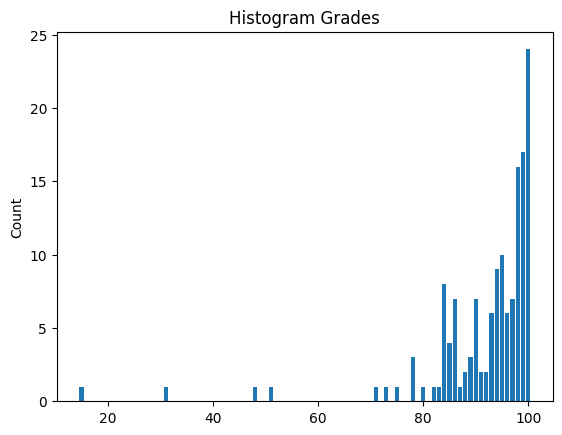

In [19]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()
print()

In [20]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#entropy,prompt_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,32.102124
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,3.0,5.991354
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,3.0,4.907994
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,3.0,2.776954
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,26.0,1.569760


In [21]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")

df.head()

,code,#user_prompts,#error,#no,#entropy,prompt_avg_chars,weighted_total
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,32.102124,30.141131
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,3.0,5.991354,79.974969
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,3.0,4.907994,38.593641
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,3.0,2.776954,30.328896
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,26.0,1.569760,77.472859


#### Merging scores with features

In [22]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df = pd.merge(temp_df, total_code_response_df, on='code', how='left')
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
# temp_df = temp_df[~temp_df['code'].isin(codes_below_50)]
# temp_df = temp_df[temp_df['#user_prompts'] >= 5]

temp_df


,code,#user_prompts,#error,#no,#entropy,prompt_avg_chars,weighted_total,grade,code_responses
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,32.102124,30.141131,48.0,14
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,3.0,5.991354,79.974969,99.0,17
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,3.0,4.907994,38.593641,90.0,7
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,3.0,2.776954,30.328896,97.0,19
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,26.0,1.569760,77.472859,100.0,82
...,...,...,...,...,...,...,...,...,...
135,f24219d6-07f0-4baf-80ac-18475dc5b66f,21.0,1.0,0.0,4.0,2.583692,55.718143,93.0,16
136,f2f18684-4a16-4c05-a2d1-c0f96d1de869,71.0,1.0,1.0,6.0,8.580530,62.665671,100.0,59
137,f852596d-fdca-45aa-9050-d4f76ce6a53c,30.0,6.0,1.0,3.0,3.177291,88.571453,98.0,25
138,f8ec3336-fd48-4654-ad98-62ccfb96d096,14.0,0.0,0.0,3.0,3.071781,92.743397,100.0,14


In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression
X = temp_df.drop(['grade', 'code'], axis=1).to_numpy()

y = temp_df["grade"].to_numpy()




print(X.shape, y.shape)
print(y)

(122, 7) (122,)
[ 48.  99.  90.  97. 100.  84.  96.  80.  89.  83.  94. 100.  84.  97.
  99. 100. 100. 100.  96.  98.  95. 100.  97. 100.  94.  99.  87.  93.
 100.  98.  88.  94.  71.  98.  95.  98.  94.  84.  84. 100.  97.  96.
 100. 100. 100.  91. 100.  97.  31.  75.  86.  84.  99.  86.  99.  90.
  97.  78.  89.  93.  90.  85. 100.  73.  99.  99.  99.  97.  99. 100.
  86.  86.  94.  95.  95.  94.  86.  99.  99. 100.  99.  91.  98.  90.
  95.  99.  93.  95.  85.  88.  78.  98.  99.  96.  93.  94. 100.  90.
 100.  90. 100.  94.  92.  92.  96.  51.  96.  95.  98.  98. 100.  89.
  95.  82.  15.  90.  85.  93. 100.  98. 100.  98.]


#### Train/Test split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))



Train set size: 97
Test set size: 25


#### Fitting a model

#### Predicting and Analyzing 

In [25]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)



DecisionTreeRegressor(max_depth=10, random_state=0)

In [26]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 163.42034222552866
Node 1 has MSE 126.39409722222263
Node 2 has MSE 278.99609375
Node 3 has MSE 121.00832342449394
Node 4 has MSE 126.46913580246928
Node 5 has MSE 36.359375
Node 6 has MSE 14.800000000000182
Node 7 has MSE 6.2222222222208075
Node 8 has MSE 0.0
Node 9 has MSE 1.0
Node 10 has MSE 0.0
Node 11 has MSE 0.0
Node 12 has MSE 1.0
Node 13 has MSE 0.0
Node 14 has MSE 0.0
Node 15 has MSE 5.555555555555657
Node 16 has MSE 0.0
Node 17 has MSE 0.0
Node 18 has MSE 0.0
Node 19 has MSE 52.347499999999854
Node 20 has MSE 28.691358024692818
Node 21 has MSE 31.888888888888687
Node 22 has MSE 28.17283950617275
Node 23 has MSE 20.859375
Node 24 has MSE 7.555555555554747
Node 25 has MSE 2.240000000000691
Node 26 has MSE 0.0
Node 27 has MSE 2.25
Node 28 has MSE 0.0
Node 29 has MSE 0.0
Node 30 has MSE 0.0
Node 31 has MSE 0.22222222222262644
Node 32 has MSE 0.0
Node 33 has MSE 0.0
Node 34 has MSE 3.3333333333339397
Node 35 has MSE 0.1875
Node 36 has MSE 0.0
Node 37 has MSE 0.0
Nod

In [27]:
# Plotting the Tree 
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

'hw.pdf'

In [28]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 1.0347079037800686
MSE TEST: 82.09173333333332
R2 Train: 0.9936684265270225
R2 TEST: 0.26877214985415543


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import pandas as pd

# Defining the neural network model
model = Sequential([
    Dense(units=64, activation='relu', input_shape=[X_train.shape[1]]),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dropout(0.2),
    Dense(units=16, activation='relu'),
    Dense(units=1, activation='sigmoid')  # No activation function for regression
])


# Compile the model for a regression problem


model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))  # Adjust the learning rate


# Show model summary
model.summary()

# Train the model for regression
model.fit(X_train, y_train, epochs=10, validation_split=0.20)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3137 (12.25 KB)
Trainable params: 3137 (12

In [30]:
from cmath import sqrt


test_metrics = model.evaluate(X_test, y_test)
print(sqrt(test_metrics))


1/1 [==============================] - 0s 38ms/step - loss: 8415.1592
(91.73417672649327+0j)


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import pandas as pd

y_min = y.min()
y_max = y.max()
y_scaled = y - y_min / y_max - y_min

# Defining the neural network model
model = Sequential([
    Dense(units=64, activation='relu', input_shape=[X_train.shape[1]]),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dropout(0.2),
    Dense(units=16, activation='relu'),
    Dense(units=1, activation='sigmoid')  # No activation function for regression
])


# Compile the model for a regression problem
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))


In [32]:
from sklearn.model_selection import KFold
import numpy as np

# Number of folds
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# To store scores for each fold
scores = []

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    # Split data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]


    model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))
    # Fit the model
    model.fit(X_train, y_train, epochs=10, batch_size=32)  # Set verbose to 0 to suppress output

    # Evaluate the model
    mse = model.evaluate(X_test, y_test, verbose=0)
    print(mse)
    # print(scores)

# Calculate average score across all folds
average_score = np.mean(scores)
print(f"Average Score across all folds: {average_score}")

Epoch 1/10
4/4 [==============================] - 1s 7ms/step - loss: 5963.5703
Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 5907.8330
Epoch 3/10
4/4 [==============================] - 0s 5ms/step - loss: 5894.9839
Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 5875.9883
Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 5876.0405
Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 5873.0947
Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 5868.8389
Epoch 8/10
4/4 [==============================] - 0s 6ms/step - loss: 5867.7734
Epoch 9/10
4/4 [==============================] - 0s 5ms/step - loss: 5865.6196
Epoch 10/10
4/4 [==============================] - 0s 3ms/step - loss: 5865.9292
5883.71923828125
Epoch 1/10
4/4 [==============================] - 1s 6ms/step - loss: 5850.7725
Epoch 2/10
4/4 [==============================] - 0s 6ms/step - loss: 5850.7061
Epoch 3/10
4/4 [======

C:\Users\alfem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\alfem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [36]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming X and y are already defined and are your features and target variable respectively.

# Min-Max scaling the target variable y
y_min = y.min()
y_max = y.max()
y_scaled = (y - y_min) / (y_max - y_min)

# Number of folds for K-Fold cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store scores for each fold
scores2 = []

# K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    # Split data into training and test sets for the current fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]
    # print(y_train)
    # Define the neural network model
    model = Sequential([
        Dense(units=32, activation='relu', input_shape=[X_train.shape[1]]),
        Dropout(0.5),
        Dense(units=16, activation='relu'),
        Dropout(0.5),
        Dense(units=8, activation='relu'),
        Dense(units=1) # No activation function for regression
        ])
    # Compile the model for a regression problem
    model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))

    # Fit the model on the training data
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)  # Set verbose to 0 to suppress output during training

    # Predict on the test data
    y_pred_scaled = model.predict(X_test, verbose=0)
    
    # Inverse scaling the predictions
    y_pred = y_pred_scaled * (y_max - y_min) + y_min

    # Inverse scaling the true test data
    y_test_original = y_test * (y_max - y_min) + y_min
    print("original:", y_test_original, " and predicted value:", y_pred)
    # Calculate the MSE on the original scale
    mse = np.mean((y_test_original - y_pred) ** 2)
    
    # print(mse)
    scores2.append(mse)
average_score = np.mean(scores2)
print(f"Average MSE across all folds: {average_score}")


original: [ 48. 100.  94. 100.  96.  94.  87.  94.  97. 100.  91.  97.  86.  90.
  97. 100.  99.  86.  88.  78. 100.  95.  98.  90.  98.]  and predicted value: [[ 1.5639987e+01]
 [-1.7785461e+02]
 [-1.3720735e+02]
 [ 5.0557701e+01]
 [-1.5111763e+02]
 [-2.0416624e+02]
 [-1.9486359e+02]
 [-1.8875824e+02]
 [-1.7721786e+02]
 [-1.7776871e-01]
 [-1.9030056e+00]
 [-1.8533589e+02]
 [-9.3097321e+01]
 [ 3.7471890e+02]
 [-2.2013956e+02]
 [-1.4117393e+02]
 [-1.6459789e+00]
 [-1.5419858e+02]
 [ 1.5291460e+01]
 [-2.3969776e+01]
 [-1.8415759e+02]
 [-1.3786656e+02]
 [-1.0226234e+02]
 [-5.5109680e+01]
 [-1.5840025e+02]]
original: [ 84.  83.  84. 100.  97.  99. 100.  88.  98.  94. 100.  99.  99. 100.
  86.  94.  99.  90.  98.  96. 100.  51.  89.  85. 100.]  and predicted value: [[  -1.0262966]
 [  91.33976  ]
 [ 145.82175  ]
 [ 127.53629  ]
 [  74.54795  ]
 [ 100.663826 ]
 [ 112.47989  ]
 [   5.5664606]
 [ 103.21831  ]
 [ 168.79079  ]
 [  98.87363  ]
 [-118.74759  ]
 [  79.67918  ]
 [  49.299625 ]
 [-11

In [57]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Create a new SnowballStemmer
stemmer = SnowballStemmer("english")

stop_words = set(stopwords.words('english'))
print(scores)
# Assuming 'scores' and 'code2convos' are defined and available
subset = scores[scores["grade"] >= 98]
code_values = subset["code"]
vocab_count = {}

def join_words(words):
    return ' '.join(words)

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

def stem_words(words):
    return [stemmer.stem(word) for word in words]

def preprocess_text(text):
    # Remove punctuation and numbers
    text = re.sub(r'[{}0-9]+'.format(re.escape(string.punctuation)), '', text.lower())
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    return tokens

for file_code in code_values:
    for chat in code2convos[file_code]:
        # Assuming 'response' is a key in the 'chat' dictionary
        processed_tokens = preprocess_text(chat['response'])
        processed_tokens = remove_stopwords(processed_tokens)
        processed_tokens = stem_words(processed_tokens)
        chat['response'] = join_words(processed_tokens)

        for word in processed_tokens:
            if word in vocab_count:
                vocab_count[word] += 1
            else:
                vocab_count[word] = 1

# Sort and display the word count
sorted_vocab = sorted(vocab_count.items(), key=lambda x: x[1], reverse=True)
for word, count in sorted_vocab:
    print(f"{word}: {count}")
len(sorted_vocab)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alfem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alfem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                     code  grade
0    6a2003ad-a05a-41c9-9d48-e98491a90499   90.0
1    04f91058-d0f8-4324-83b2-19c671f433dc   97.0
2    81fdeb2a-e7e5-4a05-8058-d31ea579b0d9   94.0
3    6a903495-c5be-4263-b4dd-75e2bbc30434   97.0
4    6d5742c1-77c4-429c-8f6e-ef1262ca5557   93.0
..                                    ...    ...
140  6c37a2d7-f786-4fc2-ba7a-04c3f961a365   89.0
141  5e481e20-f714-4f11-b941-0ef2fd5976d3   31.0
142  b24c3a33-2952-4ae4-9f2d-643d8fdbc600   78.0
143  8be8e839-6dd0-44e0-b039-170b5b77cf2a   86.0
144  a014d72a-81ad-43a4-8a2c-8046b7666320   91.0

[145 rows x 2 columns]
featur: 3758
valu: 3422
use: 3092
correl: 2671
code: 2528
variabl: 2406
column: 2299
calcul: 2122
data: 1954
tree: 1923
import: 1868
dataset: 1854
split: 1660
model: 1602
target: 1458
train: 1444
hyperparamet: 1392
datafram: 1268
entropi: 1268
miss: 1202
set: 1191
node: 1164
deci: 1123
test: 1097
inform: 1058
base: 1008
name: 974
display: 974
gain: 930
creat: 917
class: 908
label: 873


10950

In [223]:
# Flatten the dictionary
flattened_data = []
for code, convos in code2convos.items():
    for convo in convos:
        # Add the code as a key in each dictionary
        convo_with_code = convo.copy()
        convo_with_code['code'] = code
        flattened_data.append(convo_with_code)

# Create the DataFrame
df = pd.DataFrame(flattened_data)

# If you want to reorder the columns to have 'code' as the first column
df = df[['code', 'response']]  # Add other column names as needed

# Now df is your desired DataFrame
bagofwords_data = pd.merge(scores, df, on="code", how="left")
grouped_data = bagofwords_data.groupby('code').agg({'response': lambda x: list(x)}).reset_index()

# If you want to keep the 'grade' column, you need to decide how to handle multiple grades per code.
# For example, you can take the mean, max, or min. Here's an example using mean:
grouped_data = bagofwords_data.groupby('code').agg({'grade': 'mean', 'response': lambda x: list(x)}).reset_index()

# Now 'grouped_data' is your desired DataFrame
# grouped_data
grouped_data['response'] = grouped_data['response'].apply(lambda responses: ' '.join(str(response) for response in responses))
codes_to_remove = ["139235c7-736c-4237-92f0-92e8c116832c", 
                   "668ad17e-0240-49f7-b5a7-d22e502554c6", 
                   "b0640e51-6879-40cb-a4f5-329f952ef99d", 
                   "da6b70d5-29f6-491a-ad46-037c77067128"]

# Remove rows with these codes
grouped_data = grouped_data[~grouped_data['code'].isin(codes_to_remove)]
filtered_grouped_data = grouped_data[grouped_data['code'].isin(temp_df['code'])]


# filtered_grouped_data = pd.merge(filtered_grouped_data, total_code_response_df, on='code', how='left')
# filtered_grouped_data = pd.merge(filtered_grouped_data, question_mapping_scores, on='code', how='left')

temp_df2 = temp_df.drop('grade', axis=1)
filtered_grouped_data = pd.merge(filtered_grouped_data, temp_df2, on="code", how="left")

X = filtered_grouped_data[['response', 'weighted_total', 'code_responses', 'prompt_avg_chars', '#user_prompts']]
y = filtered_grouped_data['grade']

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)

print(train_data)


                                              response  weighted_total  \
42   read csv file use panda librari python use rea...       66.624324   
105  To build a decision tree classifier using the ...       45.602865   
93   To read a .csv file using the pandas library i...       50.772162   
36   Certainly! To build a decision tree classifier...       95.456386   
100  certain build deci tree classifi use scikitlea...       68.385571   
..                                                 ...             ...   
106  Certainly! To perform data preprocessing and i...       51.159733   
14   build deci tree classifi predict penguin healt...       79.759908   
92   python display summari dataset use info functi...       50.791251   
51   That's quite a comprehensive dataset! What spe...       10.032277   
102  The dataset you provided for Homework 1 includ...       78.551582   

     code_responses  prompt_avg_chars  #user_prompts  
42               20         10.580091           20.0  
1

BAG OF WORDS

In [225]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
from scipy.sparse import csr_matrix, isspmatrix
from sklearn.preprocessing import MinMaxScaler
# Get the top 300 words
vocab_list = [word for word, count in sorted_vocab[:500]]

# Initialize CountVectorizer with the top 300 words as the vocabulary
vectorizer = CountVectorizer(vocabulary=vocab_list, max_features=500, preprocessor=lambda x: x)
# vectorizer.fit_transform(train_data['response'])

scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the training labels
train_labels_normalized = scaler.fit_transform(train_labels.values.reshape(-1, 1))
test_labels_normalized = scaler.fit_transform(test_labels.values.reshape(-1, 1))
# Vectorize the responses
train_vectors = vectorizer.transform(train_data['response'])
test_vectors = vectorizer.transform(test_data['response'])

# Convert the BoW vectors to a DataFrame
train_bow_df = pd.DataFrame(train_vectors.toarray(), columns=vectorizer.get_feature_names_out())
test_bow_df = pd.DataFrame(test_vectors.toarray(), columns=vectorizer.get_feature_names_out())

# Reset the index if needed
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Concatenate the BoW DataFrame with the existing features, excluding the original 'response' column
train_data_combined = pd.concat([train_bow_df, train_data.drop('response', axis=1)], axis=1)
test_data_combined = pd.concat([test_bow_df, test_data.drop('response', axis=1)], axis=1)
 
train_data_combined_np = train_data_combined.to_numpy()
test_data_combined_np = test_data_combined.to_numpy()

# Fit the model using the NumPy arrays

model = Sequential([
    Dense(units=64, activation='relu', input_shape=[train_vectors.shape[1]+4]),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation= 'sigmoid')  # Output layer for regression
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.fit(train_data_combined_np, train_labels_normalized, epochs=10)

# Evaluate the model
predictions = model.predict(test_data_combined_np)
predictions_rescaled = scaler.inverse_transform(predictions)
mse = mean_squared_error(test_labels, predictions_rescaled)
rmse = np.sqrt(mse)
print(train_labels)
print(predictions)
print(f"RMSE: {rmse}")


Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.0603
Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0345
Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0331
Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0250
Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.0320
Epoch 6/10
4/4 [==============================] - 0s 6ms/step - loss: 0.0322
Epoch 7/10
4/4 [==============================] - 0s 5ms/step - loss: 0.0322
Epoch 8/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0320
Epoch 9/10
4/4 [==============================] - 0s 7ms/step - loss: 0.0322
Epoch 10/10
1/1 [==============================] - 0s 100ms/step
42     100.0
105     51.0
93      96.0
36      94.0
100    100.0
       ...  
106     96.0
14      99.0
92      99.0
51      84.0
102     92.0
Name: grade, Length: 97, dtype: float64
[[0.9999912 ]
 [0.9999994 ]
 [1.        ]
 [1.        ]
 [1

In [226]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_regressor.fit(train_data_combined_np, train_labels_normalized.ravel())

# Make predictions
rf_predictions = rf_regressor.predict(test_data_combined_np)
rf_predictions_rescaled = scaler.inverse_transform(rf_predictions.reshape(-1, 1))

# Evaluate the model
rf_mse = mean_squared_error(test_labels, rf_predictions_rescaled)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(test_labels, rf_predictions_rescaled)

print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R2 Score: {rf_r2}")
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# for train_index, test_index in kf.split(train_data_combined_np + test_data_combined_np):
#     print(train_data_combined_np)
#     X_train, X_test = train_data_combined_np[train_index], train_data_combined_np[test_index]
#     y_train, y_test = test_data_combined_np[train_index], test_data_combined_np[test_index]
#     rf_regressor.fit(X_train, y_train.ravel())
#     rf_predictions = rf_regressor.predict(y_test)
#     rf_mse = mean_squared_error(y_test, rf_predictions)
#     rf_rmse = np.sqrt(rf_mse)
#     rf_r2 = r2_score(y_test, rf_predictions)
#     print(f"Random Forest RMSE: {rf_rmse}")
#     print(f"Random Forest R2 Score: {rf_r2}")

# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# # Define the scorer based on RMSE

# def rmse_scorer(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

# rmse_cv_scorer = make_scorer(rmse_scorer, greater_is_better=False)
# combined_data = np.concatenate((train_data_combined_np, test_data_combined_np), axis=0)
# combined_data_label = np.concatenate((train_labels, test_labels), axis=0)
# print(combined_data_label)
# # Perform cross-validation
# # cv_results = cross_val_score(rf_regressor, train_data_combined_np, train_labels.ravel(), 
# #                              cv=kfold, scoring=rmse_cv_scorer)

# cv_results = cross_val_score(rf_regressor, combined_data, combined_data_label.ravel(), 
#                             cv=kfold, scoring=rmse_cv_scorer)

# print(-cv_results)
# # cv_results = scaler.inverse_transform(cv_results.reshape(-1, 1))





Random Forest RMSE: 8.97992297486251
Random Forest R2 Score: 0.28171214838326675


In [229]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Initialize RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=150)

# Setup KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the metrics for each fold
rmses = []
r2_scores = []
combined_data_np = np.concatenate((train_data_combined_np, test_data_combined_np), axis=0)

y = filtered_grouped_data['grade'].to_numpy().reshape(-1, 1)

# Concatenate with combined_data_np along axis 1 (columns)
combined_data_with_target_np = np.concatenate((combined_data_np, y), axis=1)

X = combined_data_with_target_np[:, :-1]
y = combined_data_with_target_np[:, -1]

for train_index, test_index in kf.split(X):
    # Splitting the data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model on training data
    rf_regressor.fit(X_train, y_train)

    # Make predictions on the test set
    rf_predictions = rf_regressor.predict(X_test)
    
    # Evaluate the model
    rf_mse = mean_squared_error(y_test, rf_predictions)
    rf_rmse = np.sqrt(rf_mse)
   

    # Store the metrics
    rmses.append(rf_rmse)
   

# Calculate the average metrics across all folds
average_rmse = np.mean(rmses)
print(rmses)
print(f"Average Random Forest RMSE across all folds: {average_rmse}")



[11.472343614100827, 12.874186187872224, 9.597266049505972, 23.142555543485976, 8.447627378935067]
Average Random Forest RMSE across all folds: 13.106795754780013


In [134]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 300
tfidf_vectorizer = TfidfVectorizer(max_features=max_features, preprocessor=lambda x: x)

# Fit the vectorizer to your train data
tfidf_vectorizer.fit_transform(train_data)

# Transform the train and test data
train_tfidf = tfidf_vectorizer.transform(train_data)
test_tfidf = tfidf_vectorizer.transform(test_data)
print(test_tfidf)
model = Sequential([
    Dense(units=64, activation='relu', input_shape=[max_features]),
    Dropout(0.3),
    Dense(units=32, activation='relu'),
    Dropout(0.3),
    Dense(units=1),
    ])

# Compile the model
# WRITE YOUR CODE HERE
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model.fit(train_tfidf.toarray(), train_labels, epochs=5)

# Evaluate the model
predictions = model.predict(test_tfidf.toarray())

mse = mean_squared_error(test_labels, predictions)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

  (0, 2)	1.0
  (1, 4)	1.0
  (2, 0)	1.0
  (3, 1)	1.0
  (4, 3)	1.0


ValueError: Data cardinality is ambiguous:
  x sizes: 5
  y sizes: 97
Make sure all arrays contain the same number of samples.

In [230]:
answer_key= [
    """df = pd.read_csv("cs412_hw1_dataset.csv")""",
    """
    # Get the shape of the DataFrame
    shape_of_data = df.shape

    # shape_of_data now contains the number of rows and columns
    print("Number of samples (rows):", shape_of_data[0])
    print("Number of attributes (columns):", shape_of_data[1])

    # Display the variable names
    variable_names = df.columns

    print("Variable Names:")
    print(variable_names)
    print("\n")

    #display information about the dataframe
    info = df.info()
    print(info)

    #display first 5 
    first_five = df.head(5)
    print(first_five)
""",
    """
    df = pd.read_csv("cs412_hw1_dataset.csv")
    print(df.head())
    missing_values = df.isna().sum()

    print("Missing values in each column:\n", missing_values)

    # Fill missing values with the most common value in each column
    for column in df.columns:
        most_common_value = df[column].mode()[0]
        df[column].fillna(most_common_value, inplace=True)

    info = df.info()
    print(info)
    """,
    """
    sex_map = {'female':1, 'male': 0}

    island_map = {'Biscoe': 1,
                'Dream': 2,
                'Torgensen': 3}

    diet_map = {'fish': 1,
                'krill': 2,
                'squid': 3,
                "parental":4}

    life_stage_map = {'chick': 1,
                'juvenile': 2,
                'adult': 3}

    health_metrics_map = {'healthy': 1,
                'overweight': 2,
                'underweight': 3}

    species_map = {'Adelie': 1,
                'Chinstrap': 2,
                'Gentoo':3}

    # code here

    df["sex"] = df["sex"].map(sex_map)
    df["island"] = df["island"].map(island_map)
    df["diet"] = df["diet"].map(diet_map)
    df["life_stage"] = df["life_stage"].map(life_stage_map)
    df["health_metrics"] = df["health_metrics"].map(health_metrics_map)
    df["species"] = df["species"].map(species_map)

    print(df.head())
    """,
    """
    from sklearn.utils import shuffle
    df = shuffle(df)
    """,
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    from sklearn.preprocessing import StandardScaler


    # Calculate correlations with 'Health Metrics'

    # selected_columns = df.drop(columns=['species'])

    # Assuming df is your DataFrame and body_mass_g is the column to be standardized
    scaler = StandardScaler()

    # StandardScaler expects a 2D array, so we use .values.reshape(-1, 1)
    df['body_mass_g_standardized'] = scaler.fit_transform(df['body_mass_g'].values.reshape(-1, 1))
    df['bill_ratio'] = df['bill_length_mm'] / df['bill_depth_mm']

    correlation_with_health = df.corr()['health_metrics'].drop('health_metrics')


    print(correlation_with_health)


    # Convert to DataFrame
    corr_df = pd.DataFrame(correlation_with_health.items(), columns=['Feature', 'Correlation with Health Metrics'])

    # Reshape for heatmap
    corr_df = corr_df.set_index('Feature').T

    # Plotting
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation of Features with Health Metrics")
    plt.show()
    """,
    """
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import classification_report

    # code here

    model = DecisionTreeClassifier(criterion='entropy', random_state=45)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))

    param_grid = {
        'max_depth': [5, 10, 15, 20],
        'min_samples_split': [4, 8, 10, 12, 14],
        'criterion': ['gini', 'entropy'],
        'min_samples_leaf': [1,3,5,7,9]
    }

    # estimator is the model we are evaluating, Decision Tree in our case
    estimator = DecisionTreeClassifier( random_state=45)

    # scoring is the score used to choose the best model
    scoring='f1_micro'

    # cv is the number of folds to use for cross validation
    cv = 5

    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv)


    grid_search.fit(X_train, y_train)

    cols_to_include = ['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_criterion', 'mean_test_score', 'std_test_score']
    results = pd.DataFrame(grid_search.cv_results_)[cols_to_include]
    results.sort_values(by='mean_test_score', ascending=False)
    """,
    """
    model_parameters = DecisionTreeClassifier(
    criterion='entropy',
    random_state=45,
    max_depth=15,
    min_samples_split=4,
    min_samples_leaf=1
    )

    model_parameters.fit(X_train, y_train)
    """,
    """
    from sklearn.tree import plot_tree

    #code here
    plt.figure(figsize=(50, 25))
    plot_tree(model_parameters, fontsize = 12)
    plt.show()
    """,
    """
    y_pred = model_parameters.predict(X_test)

    print(classification_report(y_test, y_pred))
    """,
    """
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    #code here

    cm = confusion_matrix(y_test, y_pred)

    labels = [1, 2, 3]

    # Plotting the confusion matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title('Confusion Matrix')
    plt.show()
    """,
    """
    import numpy as np
    from sklearn.datasets import load_iris

    # Function to calculate entropy
    def entropy(class_counts):
        total_count = np.sum(class_counts)
        probabilities = class_counts / total_count
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])



    # Initial entropy
    initial_class_counts = np.bincount(y_train)
    initial_entropy = entropy(initial_class_counts)


    # Entropy after the first split
    tree = model_parameters.tree_
    left_child = tree.children_left[0]
    right_child = tree.children_right[0]

    left_counts = tree.value[left_child].flatten()
    right_counts = tree.value[right_child].flatten()


    left_entropy = entropy(left_counts)
    print(left_entropy)
    right_entropy = entropy(right_counts)
    print(right_entropy)
    print(initial_entropy)
    print(right_counts )

    weighted_entropy = (np.sum(left_counts) * left_entropy + np.sum(right_counts) * right_entropy) / np.sum(initial_class_counts)

    # Information gain
    information_gain = initial_entropy - weighted_entropy
    print(f"Information Gain at the first split: {information_gain}")
    """
]

In [324]:

# Assuming code2convos and code2convos2 are your two dictionaries
# Assuming temp_df is your DataFrame and 'code' is the column with the codes you want to keep
codes_to_keep = set(temp_df['code'])

code2convos2 = {k: code2convos2[k] for k in code2convos2 if k in codes_to_keep}

code_responses = []

for code , convos in code2convos2.items():
    for conv in convos:
        code_responses.append(conv)
print(len(code_responses))

15153


In [292]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

# Original stop words from scikit-learn
original_stop_words = text.ENGLISH_STOP_WORDS

# Combine original and additional stop words into a list
combined_stop_words = list(original_stop_words)

# Token pattern that matches words with English letters only (no numbers)
# This pattern will match words that consist of two or more English letters
token_pattern = r'(?u)\b[A-Za-z]{2,}\b'

vectorizer = TfidfVectorizer(
    lowercase=True,                  # Convert all characters to lowercase
    stop_words=combined_stop_words,  # Combined stop words
    token_pattern=token_pattern,     # Custom token pattern for English letters only
)

# Fit and transform the data
vectorizer.fit(answer_key + code_responses)
features = vectorizer.get_feature_names_out()

# Now the features should exclude non-English characters and numbers
answer_key_TF_IDF = pd.DataFrame(vectorizer.transform(answer_key).toarray(), columns=vectorizer.get_feature_names_out())
answer_key_TF_IDF

,able,abs,absolute,access,accessing,according,accordingly,accordinglydf,accordinglyplt,accordinglyy,...,yx,yy,zellik,zellikleri,zelliklerin,zero,zerodivisionerror,zeroentropy,zeroprobabilities,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [302]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from spellchecker import SpellChecker

# Initialize lemmatizer and spell checker
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()
nltk_stopwords = set(stopwords.words('english'))

def preprocess_text2(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Address concatenated true/false values
    text = re.sub(r'(truefalse|falsetrue)', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove short words
    text = ' '.join([word for word in text.split() if len(word) > 2])
    # Lemmatization and stop words removal
    text = ' '.join([
        lemmatizer.lemmatize(word) for word in text.split() 
        if word not in nltk_stopwords
    ])
    # Tokenize the text
    words = text.split()

    # Only keep words that are spelled correctly
    words = [word for word in words if spell.known([word])]

    # Rejoin into a single string
    text = ' '.join(words)
    return text

# Preprocess each prompt and question
# Assuming code_responses and answer_key are lists of text strings that you want to preprocess
processed_code_responses = [preprocess_text2(response) for response in code_responses]
processed_answer_key = [preprocess_text2(response) for response in answer_key]


# Fit the vectorizer on the processed text with a strict token pattern
token_pattern = r'\b[a-zA-Z]{2,}\b'  # Only English alphabetic characters
vectorizer = TfidfVectorizer(lowercase=True, token_pattern=token_pattern)

vectorizer.fit(processed_code_responses + processed_answer_key)
features = vectorizer.get_feature_names_out()
print(features)
# Transform the questions and convert to DataFrame
answer_key_TF_IDF = pd.DataFrame(
    vectorizer.transform(processed_answer_key).toarray(), 
    columns=features
)

# Manual filtering of non-English features
english_feature_columns = [col for col in answer_key_TF_IDF.columns if re.fullmatch(r'[a-zA-Z]+', col)]
answer_key_TF_IDF = answer_key_TF_IDF[english_feature_columns]
answer_key_TF_IDF
print(user)

['ab' 'abc' 'able' ... 'youll' 'youve' 'zero']


,ab,abc,able,absolute,access,accessing,according,accordingly,accuracy,accurate,...,wrong,year,yearly,yellow,yet,york,youd,youll,youve,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [317]:
code2answers_tf_idf = dict()

for code, user_prompts in code2convos2.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    
    # Apply the same preprocessing to user_prompts
    processed_user_answers = [preprocess_text2(prompt) for prompt in user_prompts]

    # Transform preprocessed prompts into TF-IDF matrix
    prompts_TF_IDF = pd.DataFrame(
        vectorizer.transform(processed_user_answers).toarray(), 
        columns=vectorizer.get_feature_names_out()
    )

    code2answers_tf_idf[code] = prompts_TF_IDF
print(code2answers_tf_idf['58fcd378-aa29-4067-813c-bb4de525428e'].shape)

38296004-7336-4797-9db4-662a48309a1c.html
6a2003ad-a05a-41c9-9d48-e98491a90499.html
746b8f06-1e89-43b8-b73c-1121eecfc854.html
(230, 1175)


In [318]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2answers_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(answer_key_TF_IDF,user_prompts_tf_idf))
print(code2cosine)

{'0031c86e-81f4-4eef-9e0e-28037abf9883':      0         1    2    3    4    5         6    7    8    9   ...        36  \
0   0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  ...  0.000000   
1   0.0  0.218198  0.0  0.0  0.0  0.0  0.684477  0.0  0.0  0.0  ...  0.015192   
2   0.0  0.000000  0.0  0.0  0.0  0.0  0.315171  0.0  0.0  0.0  ...  0.029047   
3   0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  ...  0.000000   
4   0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  ...  0.000000   
5   0.0  0.037632  0.0  0.0  0.0  0.0  0.063191  0.0  0.0  0.0  ...  0.143228   
6   0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  ...  0.000000   
7   0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  ...  0.000000   
8   0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  ...  0.000000   
9   0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  ...  0.000000   
10  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  ... 

In [335]:
code2responsemapping = dict()
for code, cosine_scores in code2cosine.items():
    code2responsemapping[code] = code2cosine[code].max(axis=1).tolist()


response_mapping_scores = pd.DataFrame(code2responsemapping).T
response_mapping_scores.reset_index(inplace=True)
response_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
response_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

response_mapping_scores


,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,8,9,10,11
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.0,0.684477,0.771511,0.083433,0.163634,0.346124,0.039215,0.0,0.000000,0.0,0.049366,0.087031
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.0,0.541252,0.715064,0.072905,0.141445,0.312597,0.122643,0.0,0.000000,0.0,0.381705,0.276603
2,041f950b-c013-409a-a642-cffff60b9d4b,0.0,0.586551,0.447961,0.000000,0.207230,0.160572,0.194584,0.0,0.000000,0.0,0.137182,0.549220
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.0,0.451019,0.725147,0.000000,0.620508,0.153227,0.232355,0.0,0.000000,0.0,0.261511,0.427616
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.0,0.487405,0.786949,0.000000,0.469046,0.436366,0.388988,0.0,0.445317,0.0,0.475287,0.427616
...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.0,0.257019,0.581872,0.087815,0.000000,0.063319,0.216594,0.0,0.000000,0.0,0.423608,0.427616
115,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.0,0.207379,0.522995,0.258336,0.620508,0.195275,0.325117,0.0,0.153347,0.0,0.276462,0.427616
116,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.0,0.230467,0.569926,0.054011,0.620508,0.184186,0.202117,0.0,0.198225,0.0,0.314533,0.470118
117,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.0,0.319471,0.610846,0.000000,0.365139,0.238191,0.186223,0.0,0.213190,0.0,0.373875,0.418748


In [342]:
codes_in_response_mapping = set(response_mapping_scores['code'])

# Create a boolean mask for rows in temp_df where 'code' is in the codes of response_mapping_scores
mask = temp_df['code'].isin(codes_in_response_mapping)

# Filter temp_df using the mask
filtered_temp_df = temp_df[mask]
grades = filtered_temp_df["grade"].to_numpy()
response_mapping_scores2 = response_mapping_scores.drop('code', axis=1)
X_train, X_test, y_train, y_test = train_test_split(response_mapping_scores2, grades, test_size=0.2, random_state=42)
print(X_train)
print(y_train)

     Q_0       Q_1       Q_2       Q_3       Q_4       Q_5       Q_6  Q_7  \
44   0.0  0.142546  0.581872  0.000000  0.000000  0.195275  0.166448  0.0   
12   0.0  0.359995  0.307194  0.000000  0.078567  0.319188  0.137887  0.0   
15   0.0  0.679790  0.522056  0.406883  0.158569  0.116680  0.233550  0.0   
70   0.0  0.300615  0.585993  0.000000  0.000000  0.169510  0.119338  0.0   
108  0.0  0.113248  0.119352  0.000000  0.000000  0.283170  0.116246  0.0   
..   ...       ...       ...       ...       ...       ...       ...  ...   
106  0.0  0.564955  0.705564  0.148997  0.106716  0.133893  0.149984  0.0   
14   0.0  0.482392  0.624555  0.000000  0.620508  0.235212  0.253923  0.0   
92   0.0  0.640579  0.610846  0.000000  0.183062  0.365186  0.172113  0.0   
51   0.0  0.685814  0.624498  0.000000  0.620508  0.430788  0.451398  0.0   
102  0.0  0.376619  0.190743  0.000000  0.620508  0.336319  0.158838  0.0   

            8    9        10        11  
44   0.000000  0.0  0.116194  0.49

In [344]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming X_train and X_test are your feature DataFrames
# Convert column names to strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Initialize the RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test data
rf_predictions = rf_regressor.predict(X_test)

# Evaluate the model
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_predictions)

print(f"Random Forest RMSE: {rf_rmse}")
print(f"Random Forest R2 Score: {rf_r2}")


Random Forest RMSE: 11.009707080572126
Random Forest R2 Score: 0.09579539991711561
